## GAN (generative adversarial networks) - 
### generowanie obrazków twarzy ludzi

#### Rozdział 1-  Przygotowanie bazy danych

Celem ponższej pracy będzie próba wygenerowania obrazków twarzy ludzi przy ućyciu GAN. W tym celu musimy najpier przygotować bazę danych, na której będziemy trenowac nasz model. W poniższej pracy użyjemy bazy danych Flickr-Faces-HQ dataset (FFHQ), która zawiera bardzo duży zbóir zdjęć. Będziemy korzystać z  15 tysięcy obrazków o wielkości 128x128px. Z racji tego, że będziemy generować zdjęcia 64x64px, przetworzymy je najpierw do takiego rozmiaru.

Poniżej mamy funkcj, która wyświetli nam losowo wylosowane zdjęcia z naszej bazy danych.

In [36]:
DATA_PATH = '/Users/anna/Desktop/int-ob/gan/faces_small/'

In [37]:
import os
import random
import matplotlib.pyplot as plt

def display_random_images(data_path, preview_rows, preview_cols, generate_square, preview_margin):
    images = []
    for i in range(preview_rows*preview_cols):
        file_path = os.path.join(data_path, random.choice(os.listdir(data_path)))
        image = plt.imread(file_path)
        images.append(image)
    
    fig, axs = plt.subplots(preview_rows, preview_cols, figsize=(preview_cols*2, preview_rows*2),
                            sharex=True, sharey=True, gridspec_kw={'wspace':0.025, 'hspace':0.025})
    
    for i, ax in enumerate(axs.flatten()):
        img = images[i]
        ax.imshow(img)
        ax.axis('off')
    
    plt.show()


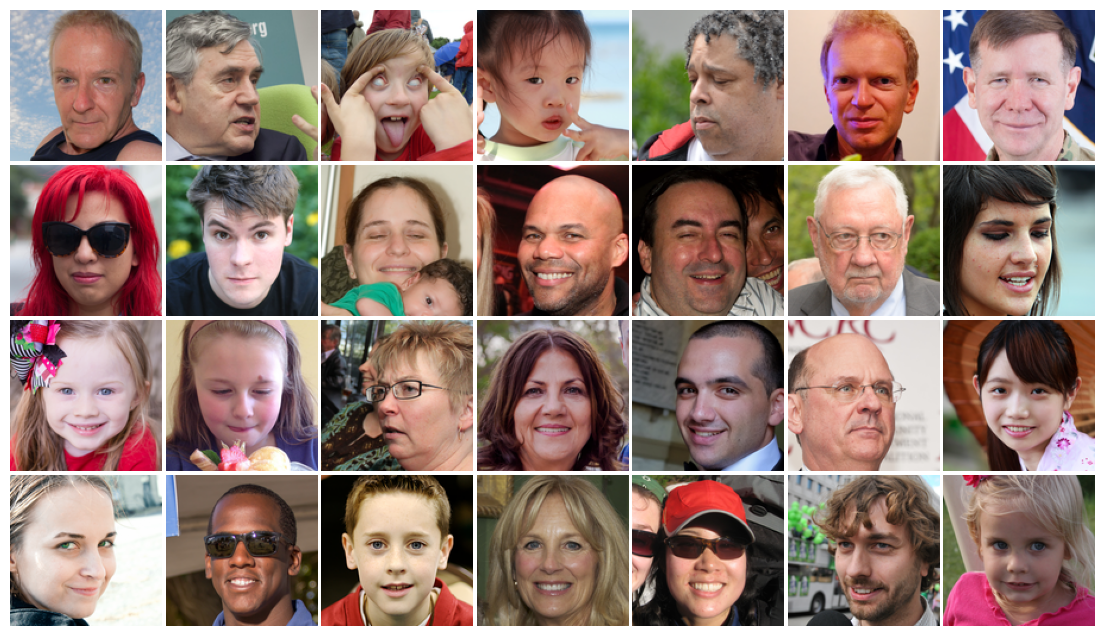

In [38]:
display_random_images(DATA_PATH, 4, 7, 64, 32)


### Rozdział 2 - preprocessing bazy danych

In [39]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Reshape, Dropout, Dense 
from tensorflow.keras.layers import Flatten, BatchNormalization
from tensorflow.keras.layers import Activation, ZeroPadding2D
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import UpSampling2D, Conv2D, Conv2DTranspose
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.optimizers import Adam
import numpy as np
from PIL import Image
from tqdm import tqdm
import os 
import time
import matplotlib.pyplot as plt

W celach pomocniczych napiszemy funkcję, która będzie mierzyła czas całego treningu dla danych parametrów.

In [40]:
def mesure_training_time(sec_elapsed):
    h = int(sec_elapsed / (60 * 60))
    m = int((sec_elapsed % (60 * 60)) / 60)
    s = sec_elapsed % 60
    return "{}:{:>02}:{:>05.2f}".format(h, m, s)

Deklarujmey potrzebne zmienne: rozmiar zdjęć, ilość kanałów, ile kolumn i rzędów będą miały templatki, które będą reprezentowały jak wyglądają generowane zdjęcia na przesdtrzeni epok oraz parametry konfiguracyjne, które będziemy zmieniać dla różnych uruchomień

In [41]:


GENERATE_RES = 2 
# (1=32, 2=64, 3=96, 4=128, etc.)
GENERATE_SQUARE = 32 * GENERATE_RES 
IMAGE_CHANNELS = 3


PREVIEW_ROWS = 4
PREVIEW_COLS = 7
PREVIEW_MARGIN = 32


SEED_SIZE = 100
EPOCHS = 50
BATCH_SIZE = 32
BUFFER_SIZE = 60000

print(f"Will generate {GENERATE_SQUARE}px square images.")

Will generate 64px square images.


Ładujemy zdjęcia z bazy.Z racji tego, że korzystamy z 15 tysięcy zdjęć w celu zaoszczędzenia czasu przy kolejnych puszczeniach na tych samych danych, będizemy zapisywać już przeprocesowane zdjęcia w osobnym pliku.

Podczas eksperymentów z generowaniem obrazków będziemy korzystać z dwóch typów tych samych obrazków:
1. Ze zmniejszonym rozmiarem do 64x64px
2. Ze zmniejszonym rozmiarem do 64x6xpx oraz ze zmienieniem na skalę szarości. 

In [42]:
training_binary_path = os.path.join(DATA_PATH,
        f'training_data_{GENERATE_SQUARE}_{GENERATE_SQUARE}.npy')

print(f"Looking for file: {training_binary_path}")

if not os.path.isfile(training_binary_path):
  start = time.time()
  print("Loading training images...")

  training_data = []
  i = 0
  for filename in tqdm(os.listdir(DATA_PATH)):
    if i <= 15000:
      path = os.path.join(DATA_PATH,filename)
      image = Image.open(path).resize((GENERATE_SQUARE,
            GENERATE_SQUARE),Image.ANTIALIAS)
      # image = tf.image.rgb_to_grayscale(image)
      training_data.append(np.asarray(image))
      i +=1
  training_data = np.reshape(training_data,(-1,GENERATE_SQUARE,
            GENERATE_SQUARE,IMAGE_CHANNELS))
  
  training_data = training_data.astype(np.float32)
  training_data = training_data / 127.5 - 1.


  print("Saving training image binary...")
  np.save(training_binary_path,training_data)
  elapsed = time.time()-start
  print (f'Image preprocess time: {mesure_training_time(elapsed)}')
else:
  print("Loading previous training pickle...")
  training_data = np.load(training_binary_path)

Looking for file: /Users/anna/Desktop/int-ob/gan/faces_small/training_data_64_64.npy
Loading previous training pickle...


In [43]:
# Batch and shuffle the data
train_dataset = tf.data.Dataset.from_tensor_slices(training_data) \
    .shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

KeyboardInterrupt: 

### Rozdział 3 - Model 1

Budujemy nasz pierwszy model generatora i dyskryminatora, który będzie wyglądał jak poniżej:

In [ ]:
def build_generator(seed_size, channels):
    model = Sequential()

    model.add(Dense(4*4*256,activation="relu",input_dim=seed_size))
    model.add(Reshape((4,4,256)))

    model.add(UpSampling2D())
    model.add(Conv2D(256,kernel_size=3,padding="same"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Activation("relu"))

    model.add(UpSampling2D())
    model.add(Conv2D(256,kernel_size=3,padding="same"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Activation("relu"))
   
    # Output resolution, additional upsampling
    model.add(UpSampling2D())
    model.add(Conv2D(128,kernel_size=3,padding="same"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Activation("relu"))

    if GENERATE_RES>1:
      model.add(UpSampling2D(size=(GENERATE_RES,GENERATE_RES)))
      model.add(Conv2D(128,kernel_size=3,padding="same"))
      model.add(BatchNormalization(momentum=0.8))
      model.add(Activation("relu"))

    # Final CNN layer
    model.add(Conv2D(channels,kernel_size=3,padding="same"))
    model.add(Activation("tanh"))

    return model


def build_discriminator(image_shape):
    model = Sequential()

    model.add(Conv2D(32, kernel_size=3, strides=2, input_shape=image_shape, 
                     padding="same"))
    model.add(LeakyReLU(alpha=0.2))

    model.add(Dropout(0.25))
    model.add(Conv2D(64, kernel_size=3, strides=2, padding="same"))
    model.add(ZeroPadding2D(padding=((0,1),(0,1))))
    model.add(BatchNormalization(momentum=0.8))
    model.add(LeakyReLU(alpha=0.2))

    model.add(Dropout(0.25))
    model.add(Conv2D(128, kernel_size=3, strides=2, padding="same"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(LeakyReLU(alpha=0.2))

    model.add(Dropout(0.25))
    model.add(Conv2D(256, kernel_size=3, strides=1, padding="same"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(LeakyReLU(alpha=0.2))

    model.add(Dropout(0.25))
    model.add(Conv2D(512, kernel_size=3, strides=1, padding="same"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(LeakyReLU(alpha=0.2))

    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid'))

    return model

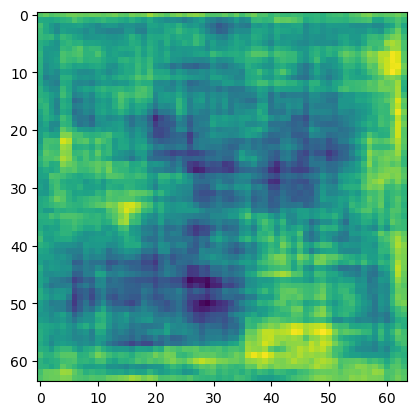

In [44]:
generator = build_generator(SEED_SIZE, IMAGE_CHANNELS)

noise = tf.random.normal([1, SEED_SIZE])
generated_image = generator(noise, training=False)

plt.imshow(generated_image[0, :, :, 0])

In [48]:
image_shape = (GENERATE_SQUARE,GENERATE_SQUARE,IMAGE_CHANNELS)

discriminator = build_discriminator(image_shape)


Funkcje do obliczania straty dla dyskryminatora i generatora

In [ ]:

cross_entropy = tf.keras.losses.BinaryCrossentropy()

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

Definiujemy funkcję pomocniczą, która będzie zapisywała wyniki generowanych obrazków po każdej epoce na templatce 7 kolumn x 4 rzędy, w celu prównania ostatecznych rezultatów dla róznych parametrów, oraz stworzenia animacji jak prezentowały się zmiany.

In [ ]:
def save_images(cnt,noise):
  image_array = np.full(( 
      PREVIEW_MARGIN + (PREVIEW_ROWS * (GENERATE_SQUARE+PREVIEW_MARGIN)), 
      PREVIEW_MARGIN + (PREVIEW_COLS * (GENERATE_SQUARE+PREVIEW_MARGIN)), IMAGE_CHANNELS), 
      255, dtype=np.uint8)
  
  generated_images = generator.predict(noise)

  generated_images = 0.5 * generated_images + 0.5

  image_count = 0
  for row in range(PREVIEW_ROWS):
      for col in range(PREVIEW_COLS):
        r = row * (GENERATE_SQUARE+16) + PREVIEW_MARGIN
        c = col * (GENERATE_SQUARE+16) + PREVIEW_MARGIN
        image_array[r:r+GENERATE_SQUARE,c:c+GENERATE_SQUARE] \
            = generated_images[image_count] * 255
        image_count += 1

          
  output_path = os.path.join(DATA_PATH,'output')
  if not os.path.exists(output_path):
    os.makedirs(output_path)
  
  filename = os.path.join(output_path,f"train-{cnt}.png")
  im = Image.fromarray(image_array)
  im.save(filename)

Będziemy korzystać z optymalizatora Adam

In [28]:
generator_optimizer = tf.keras.optimizers.legacy.Adam(1.5e-4,0.5)
discriminator_optimizer =tf.keras.optimizers.legacy.Adam(1.5e-4,0.5)

Poniżej mamy funkcję, która przedstawia  jedną iterację w GAN. W każdej iteracji losujemy próbkę danych treningowych, a następnie używamy generatora do wygenerowania fałszywych obrazów na podstawie szumów losowych. Dyskryminator otrzymuje zarówno prawdziwe jak i fałszywe obrazy i stara się odróżnić jedne od drugich. Następnie obliczamy straty dla obu sieci i aktualizujemy ich wagi przy użyciu algorytmu optymalizacji. Proces ten powtarza się wielokrotnie (funkcja train), ąz do momentu przejścia przez wszysktie epoki, których liczbę ustaliliśmy.

In [29]:
@tf.function
def train_step(images):
  seed = tf.random.normal([BATCH_SIZE, SEED_SIZE])

  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
    generated_images = generator(seed, training=True)

    real_output = discriminator(images, training=True)
    fake_output = discriminator(generated_images, training=True)

    gen_loss = generator_loss(fake_output)
    disc_loss = discriminator_loss(real_output, fake_output)
    

    gradients_of_generator = gen_tape.gradient(\
        gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(\
        disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(
        gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(
        gradients_of_discriminator, 
        discriminator.trainable_variables))
  return gen_loss,disc_loss

In [30]:
def train(dataset, epochs):
  fixed_seed = np.random.normal(0, 1, (PREVIEW_ROWS * PREVIEW_COLS, 
                                       SEED_SIZE))
  start = time.time()

  for epoch in range(epochs):
    epoch_start = time.time()

    gen_loss_list = []
    disc_loss_list = []

    for image_batch in dataset:
      t = train_step(image_batch)
      gen_loss_list.append(t[0])
      disc_loss_list.append(t[1])

    g_loss = sum(gen_loss_list) / len(gen_loss_list)
    d_loss = sum(disc_loss_list) / len(disc_loss_list)

    epoch_elapsed = time.time()-epoch_start
    print (f'Epoch {epoch+1}, gen loss={g_loss},disc loss={d_loss},'\
           f' {mesure_training_time(epoch_elapsed)}')
    save_images(epoch,fixed_seed)

  elapsed = time.time()-start
  print (f'Training time: {mesure_training_time(elapsed)}')

Do przeprowadzenia całego procesu trenignowego bedziemy korzystać z GPU, który pozwala na szybsze przetwarzanie dużej ilości danych niż CPU.

In [31]:
with tf.device('/device:GPU:0'):
    device_name = tf.test.gpu_device_name()
    if device_name != '/device:GPU:0':
        print('GPU device not found')
    else:
        print('Found GPU at: {}'.format(device_name))
    train(train_dataset, EPOCHS)
    

Found GPU at: /device:GPU:0
Epoch 1, gen loss=0.5115950703620911,disc loss=2.8735079765319824, 0:01:15.04
1/1 [==============================] - 0s 321ms/step
Epoch 2, gen loss=0.8584743142127991,disc loss=1.4902210235595703, 0:01:10.98
1/1 [==============================] - 0s 132ms/step
Epoch 3, gen loss=0.8542228937149048,disc loss=1.4541621208190918, 0:01:14.92
1/1 [==============================] - 0s 98ms/step
Epoch 4, gen loss=0.916235089302063,disc loss=1.3837014436721802, 0:01:18.85
1/1 [==============================] - 0s 100ms/step
Epoch 5, gen loss=0.9560903310775757,disc loss=1.3300107717514038, 0:01:23.82
1/1 [==============================] - 0s 96ms/step
Epoch 6, gen loss=0.9893401265144348,disc loss=1.300193190574646, 0:01:24.18
1/1 [==============================] - 0s 91ms/step
Epoch 7, gen loss=1.0391801595687866,disc loss=1.2385163307189941, 0:01:33.45
1/1 [==============================] - 0s 103ms/step
Epoch 8, gen loss=1.0551881790161133,disc loss=1.21751213073

#### 1.1 - Wyniki dla pierwszego uruchomienia 

Pierwsze uruchomienie odbyło się dla następujących parametrów:
15 tysiecy zdjęć  
64x64px  

In [ ]:
EPOCHS = 39
SEED_SIZE = 250
BATCH_SIZE = 32
BUFFER_SIZE = 60000

oraz dla domyślnych ustawień optymalizatora Adam:

In [ ]:
generator_optimizer = tf.keras.optimizers.legacy.Adam()
discriminator_optimizer =tf.keras.optimizers.legacy.Adam()

Tak prezentują się wyniki w postaci gifu oraz tego jak wygladają wygenerowane obrazki po 40 epokach:

In [139]:
from IPython.display import HTML
from IPython.display import Image


HTML('<img src="/Users/anna/Desktop/int-ob/gan/gan_01.gif">')

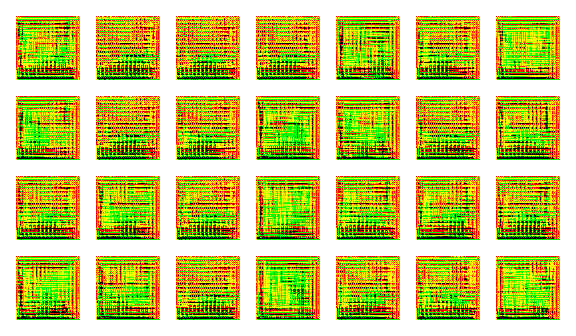

In [141]:

Image(filename='/Users/anna/Desktop/int-ob/gan/output_01/train-38.png')

Jak widać w żaden sposób nie przypominają one twarzy są tylko zbiorem kolorowych punktów. Spróbujemy zmienic parametry i zobaczyć wyniki dla tego samego dyskryminatora i generatora ze zmienionymi parametrami.

### 1.2  Wyniki dla drugiego uruchmienia

Parametry:  
15 tysięcy zdjęć  
64x64px  

In [ ]:
EPOCHS = 50 
SEED_SIZE = 100
BATCH_SIZE = 32
BUFFER_SIZE = 60000

oraz mniejsze tempo uczenia dla optymalizatora Adam

In [ ]:
generator_optimizer = tf.keras.optimizers.legacy.Adam(1.5e-4,0.5)
discriminator_optimizer =tf.keras.optimizers.legacy.Adam(1.5e-4,0.5)

In [156]:
HTML('<img src="gan_02.gif">')

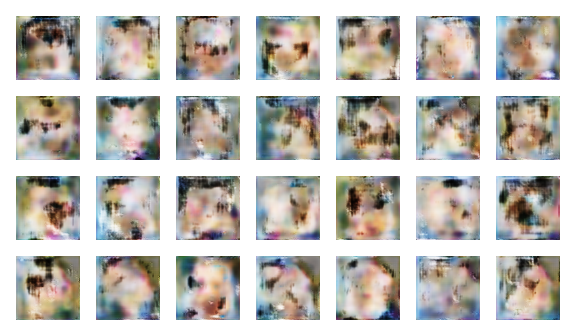

In [154]:
Image(filename='output_02/train-49.png')

Zmiana parametrów przyniosła dużą różnićę. Zdjęcia dalej nie są twarzami, ale na niektórym obrazkach możba dostrzec zarysy twarz czy nawet oczu. 

Sprawdzimy więc czy uzycie skali szarości poprawi te rezultaty.

### 1.3 Wyniki dla trzeciego uruchomienia

Parametry względem drugiego uruchomienia różnią się tylko tym, że zdjęcia zostały dodatkowo przetworzone po przez użycie skali szarości na nich.

Wyniki:

In [155]:
HTML('<img src="gan_03.gif">')

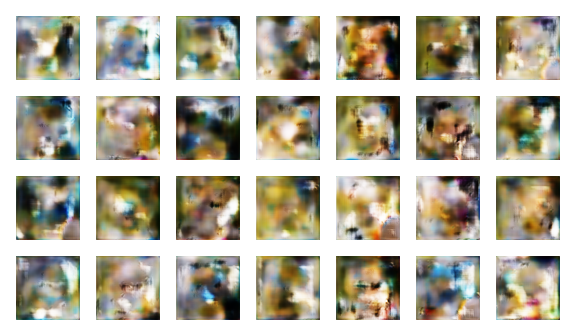

In [157]:
Image(filename='output_03/train-49.png')

Tutaj wyniki są nieznacznie gorsze, ale analizując obrazki na pojedynczych możemy czasami zobczyć  bardzo zniekształcony fragemtn twarzy lub oczu

1.4 Wyniki czwartego uruchomienia

Z racji tego, że wyniki drugiego uruchomienia były najbardzoej obiecujące spróbujemy uruchomić program dla takich samych parametrów, jak podczas drugiego uruchomienia, ale dla 250 epok, a nie 50

Wyniki:

In [167]:
HTML('<img src="gan_07.gif">')

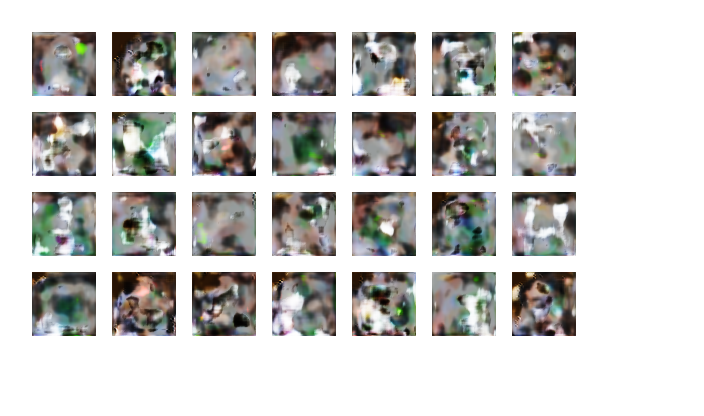

In [170]:
Image(filename='output_07/train-249.png')

Analizując wynikimożna zobaczyć, że nie doszło do poprawy, a nawet rezultaty się pogorszyły

### Model 2 - nowy generator i dyskryminator

Spróbujemy zmienić wewnętrzną strukture generatora i dyskryminatora i sprawdzić jak to wpłynie na nasze wyniki

Podsumowując różnicę między modelem 1, a modelem 2:

W budowie nowego generatora:

użyto warstw Conv2DTranspose zamiast UpSampling2D i Conv2D  
oraz użyto batch normalization po każdej warstwie Conv2DTranspose  
zmieniono strukturę - zmniejszono ilość warstw i zastosowano mniejsze filtry


W budowie nowego dyskryminatora:

usunięto jedną warstwę Conv2D i jedną warstwę Dropout
zmniejszono ilość filtrów w warstwach Conv2D.



In [ ]:
def build_generator(seed_size, channels):
    model = Sequential()

    model.add(Dense(256*4*4, activation="relu", input_dim=seed_size))
    model.add(Reshape((4, 4, 256)))

    model.add(Conv2DTranspose(256, kernel_size=4, strides=2, padding="same"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Activation("relu"))

    model.add(Conv2DTranspose(128, kernel_size=4, strides=2, padding="same"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Activation("relu"))

    model.add(Conv2DTranspose(64, kernel_size=4, strides=2, padding="same"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Activation("relu"))

    model.add(Conv2DTranspose(channels, kernel_size=4, strides=2, padding="same"))
    model.add(Activation("tanh"))

    return model


def build_discriminator(image_shape):
    model = Sequential()

    model.add(Conv2D(32, kernel_size=3, strides=2, input_shape=image_shape, 
                     padding="same"))
    model.add(LeakyReLU(alpha=0.2))

    model.add(Conv2D(64, kernel_size=3, strides=2, padding="same"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(LeakyReLU(alpha=0.2))

    model.add(Conv2D(128, kernel_size=3, strides=2, padding="same"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(LeakyReLU(alpha=0.2))

    model.add(Conv2D(256, kernel_size=3, strides=2, padding="same"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(LeakyReLU(alpha=0.2))

    model.add(Conv2D(512, kernel_size=3, strides=2, padding="same"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(LeakyReLU(alpha=0.2))

    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid'))

    return model

### 2.1 Wyniki pierwszego uruchomienia 

Parametry są takie same jak dla trzeciego uruchomienia modelu 1, tylko z użyciem nowego dyskryminatora i nowego generatora, czyli:  
15 tysięcy zdjęc   
64x64px  
gray scale 

In [ ]:
EPOCHS = 50 
SEED_SIZE = 100
BATCH_SIZE = 32
BUFFER_SIZE = 60000

In [ ]:
generator_optimizer = tf.keras.optimizers.legacy.Adam(1.5e-4,0.5)
discriminator_optimizer =tf.keras.optimizers.legacy.Adam(1.5e-4,0.5)

Wyniki:

In [158]:
HTML('<img src="gan_04.gif">')

Twarze po 50 epokach:

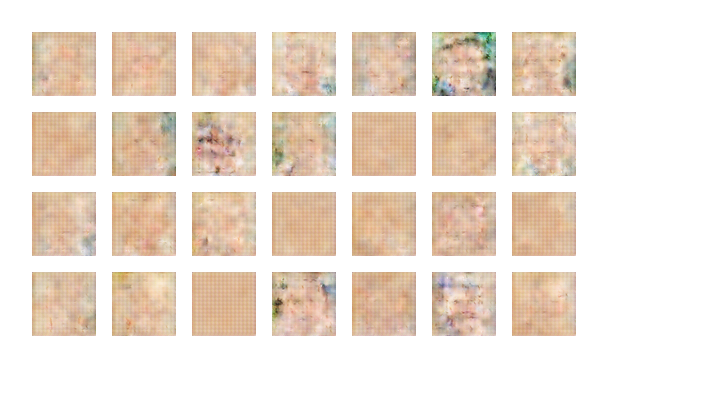

In [160]:
Image(filename='output_04/train-49.png')

Twarze po 13 epokach:

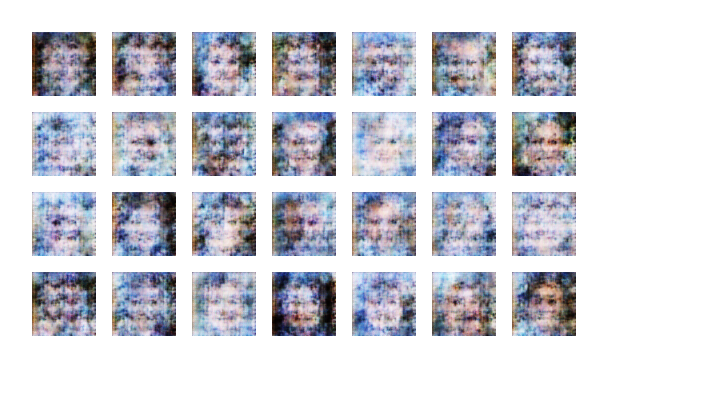

In [161]:
Image(filename='output_04/train-13.png')

Patrząc na rezultaty na gifie można dostrzec już niewyraźnie i zniekształcone rysy twarzy, czy nawet uśmiech. Jednak patrząc na rezultaty w trakcjie trwania epok mozna zobaczyć, że im dłużej trenujemy nasz model tym gorsze dostajemy wyniki.

### 2.2 Wyniki drugiego uruchomienia

Parametry zmienimy nieznacznie usuwając tylko gray scale oraz zwiększając liczbę epok do 82, żeby sprawdzić, czy znacząco wpłynie to na rezultaty.

15 tysięcy zdjęć  
64x64px

In [ ]:
EPOCHS = 82 
SEED_SIZE = 100
BATCH_SIZE = 32
BUFFER_SIZE = 60000

In [ ]:
generator_optimizer = tf.keras.optimizers.legacy.Adam(1.5e-4,0.5)
discriminator_optimizer =tf.keras.optimizers.legacy.Adam(1.5e-4,0.5)

In [162]:
HTML('<img src="gan_05.gif">')

Po 82 epokach:

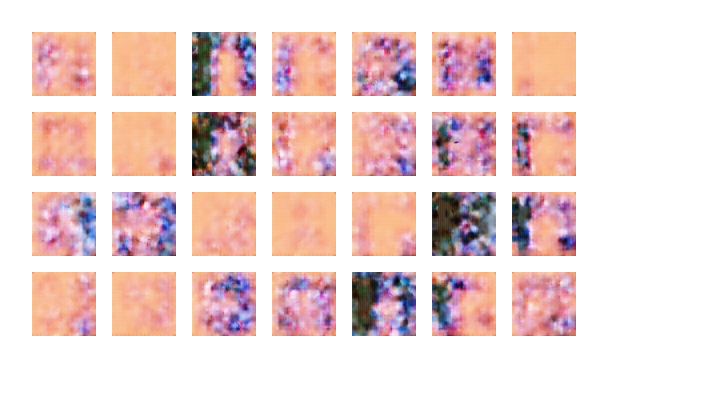

In [163]:
Image(filename='output_05/train-81.png')

Po 50 epokach:

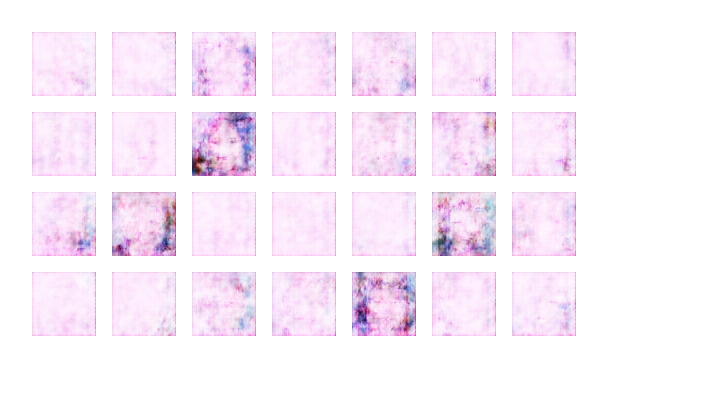

In [164]:
Image(filename='output_05/train-49.png')

Patrząc na dane oraz analizując obrazki można zobaczyć, że mniej więcje po 50 epoce generowane obrazki zupełnie tracą jakiekoliwek podobieństwa do twarzy i nic nie da się na nich rozpoznać, a najlepiej wygenerowane obrazki były mniej wiećej do 20 epoki, potem zaczeły się już głownie pogarszać.

## Rozdział 3 - nowy model dyskryminatora i generatora.

Spróbujemy usprawnić drugi model, ponieważ z racji na mniejszą ilość warstw działał on 2 razy szybciej od pierwszego modelu, i najlpesze rezultaty dawał bardzo szybko.

##### Głowne różnice względem modelu 2

Generator:
dodano jedną dodatkową warstwę konwolucyjną
dodano dodatkowe neurony do każdej z warstw
zwiększono rozmiar warstwy wejściowej z 100 do 128.


zwiększono rozmiar wejściowy obrazu z 28x28 do 32x32 pikseli
zwiększono liczbę filtrów w pierwszej warstwie konwolucyjnej z 16 do 32
dodano jedną dodatkową warstwę konwolucyjną i jedną warstwę Dense w stosunku do  modelu 2

In [ ]:
def build_generator(seed_size, channels):
    model = Sequential()

    model.add(Dense(256*6*6, activation="relu", input_dim=seed_size))
    model.add(Reshape((6, 6, 256)))

    model.add(Conv2DTranspose(256, kernel_size=4, strides=2, padding="same"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Activation("relu"))

    model.add(Conv2DTranspose(128, kernel_size=4, strides=2, padding="same"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Activation("relu"))

    model.add(Conv2DTranspose(64, kernel_size=4, strides=2, padding="same"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Activation("relu"))
    
    model.add(Conv2DTranspose(32, kernel_size=4, strides=2, padding="same"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Activation("relu"))

    model.add(Conv2DTranspose(channels, kernel_size=3, strides=1, padding="same"))
    model.add(Activation("tanh"))

    return model

def build_discriminator(image_shape):
    model = Sequential()

    model.add(Conv2D(32, kernel_size=3, strides=2, input_shape=image_shape, 
                     padding="same"))
    model.add(LeakyReLU(alpha=0.2))

    model.add(Conv2D(64, kernel_size=3, strides=2, padding="same"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(LeakyReLU(alpha=0.2))

    model.add(Conv2D(128, kernel_size=3, strides=2, padding="same"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(LeakyReLU(alpha=0.2))

    model.add(Conv2D(256, kernel_size=3, strides=2, padding="same"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(LeakyReLU(alpha=0.2))

    model.add(Conv2D(512, kernel_size=3, strides=2, padding="same"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(LeakyReLU(alpha=0.2))

    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid'))

    return model

### 3.1 Wyniki pierwszego uruchomienia 

Parametry:  
15 tysięcy zdjęć   
64x64px  

In [ ]:
EPOCHS = 50 
SEED_SIZE = 100
BATCH_SIZE = 32
BUFFER_SIZE = 60000

In [ ]:
generator_optimizer = tf.keras.optimizers.legacy.Adam(1.5e-4,0.5)
discriminator_optimizer =tf.keras.optimizers.legacy.Adam(1.5e-4,0.5)

In [165]:
HTML('<img src="gan_06.gif">')

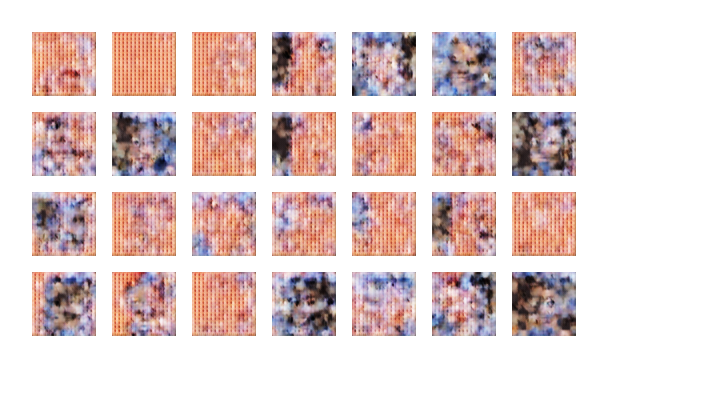

In [166]:
Image(filename='output_06/train-49.png')

Wprowadzone zmiany znacznie pogorszyły wyniki.

#### Rozdział 4 - zmiana bazy danych

Patrząc na wyniki poprzednich modeli widizmy, że nie są one zbyt dobre, być może problemem jest baza danych, która jest zbyt zróżnicowana i modele musiały by być o wiele większe i pracowac na większej ilości danych niż tylko 15 tysięcy, dlatego sprawdzimy jak będą prezentowały się wyniki dla o wiele mniej zróznicowanej bazy danych - Kaggle faces_data_new 

Tak prezentuje się ta baza:

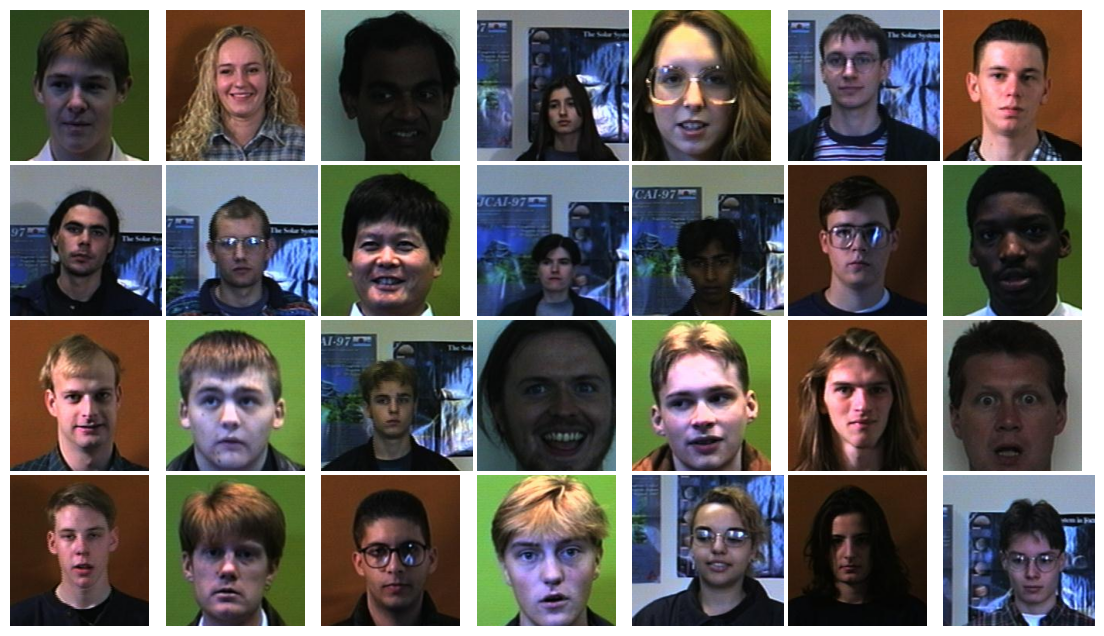

In [173]:
DATA_PATH = "/Users/anna/Desktop/int-ob/gan/images"
display_random_images(DATA_PATH, 4, 7, 64, 32)

4.1 Wyniki dla uruchomienia

Z racji tego, że na razie najbardziej obiecujące były wyniki dla drugiego uruchomienia dla modelu 1. uruchomimy to z tymi samymy parametrami.

Wyniki:

In [174]:
HTML('<img src="gan_08.gif">')

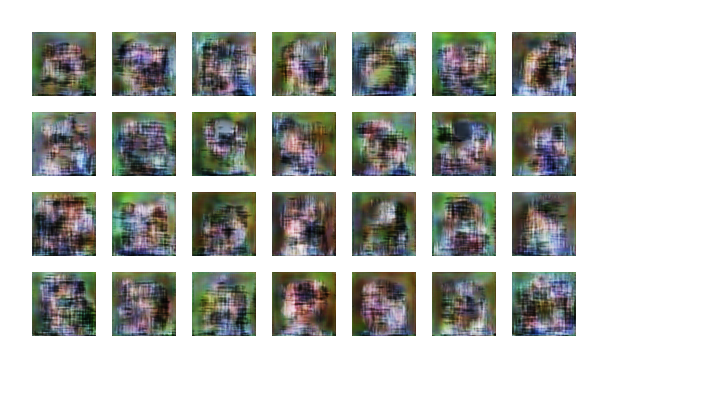

In [175]:
Image(filename='output_08/train-49.png')

Można zobaczyć, że wyniki prezentują się porównywalie w porówaniu do tych z modelu 1 z drugiego uruchomienia

#### Podsumowanie

Nie udało się wygenerować twarzy ludzi, a jedynie niektóre jej fragmenty w sposób bardzo zniekształcony. Problelem mogła być baza danych, która była zróznicowana pod względem tła, płci, koloru skóry czy wieku lub to że trzeba by trenować siec na o wiele większej ilości epok lub obrazków.

### Bibliografia

Datasets:  
Flickr-Faces-HQ dataset (FFHQ) - https://github.com/NVlabs/ffhq-dataset  
Kaggle faces_data_new - https://www.kaggle.com/datasets/gasgallo/faces-data-new  

Articles:  
https://courses.engr.illinois.edu/ie534/fa2019/GAN.html   
https://github.com/soumith/ganhacks  
https://medium.com/intel-student-ambassadors/tips-on-training-your-gans-faster-and-achieve-better-results-9200354acaa5  
https://medium.com/data-science-365/all-you-need-to-know-about-batch-size-epochs-and-training-steps-in-a-neural-network-f592e12cdb0a  
https://towardsdatascience.com/epoch-vs-iterations-vs-batch-size-4dfb9c7ce9c9
https://www.tensorflow.org/tutorials/generative/dcgan?hl=pl  
https://keras.io/examples/generative/conditional_gan/  
https://towardsdatascience.com/gan-by-example-using-keras-on-tensorflow-backend-1a6d515a60d0  
https://blog.paperspace.com/face-generation-with-dcgans/  

